In [1]:
import os
import gc
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
import torchvision.utils as vutils
import numpy as np


In [3]:
!nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Current using: ',device)

Wed Sep  8 09:09:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
           
class CBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class CBLR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBLR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class TCBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=4, stride=2, padding=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(TCBR, self).__init__(
            nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )                    


In [5]:
                                            
class Generator(nn.Module):
    def __init__(self, latents):
        super(Generator, self).__init__()
        
        self.layer1= nn.Sequential(
            # input is random_Z,  state size. latents x 1 x 1 
            # going into a convolution
            TCBR(latents, 256, 4, 2, 1),  # state size. 256 x 2 x 2
            CBR(256, 128, 3, 1)
        )
        
        self.layer2= nn.Sequential(
            TCBR(128, 256, 4, 1, 0), # state size. 256 x 3 x 3
            TCBR(256, 256, 4, 2, 1), # state size. 256 x 6 x 6
            
        )
        self.layer3= nn.Sequential(
            TCBR(256, 128, 4, 1, 0), # state size. 256 x 7 x 7
            TCBR(128, 128, 4, 2, 1),  # state size. 256 x 14 x 14
            CBR(128, 128, 3, 1)
            # state size. 256 x 6 x 6

        )
        self.layer4= nn.Sequential(
            TCBR(128, 64, 4, 2, 1), # state size. 64 x 28 x 28
            CBR(64, 64, 3, 1),
            CBR(64, 64, 3, 1),
            nn.Conv2d(64, 1, 3, 1, 1), # state size. 1 x 28 x 28
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            CBLR(1, 32, 3, 2), # b*32*14*14
            CBLR(32, 64, 3, 1), # b*64*14*14
            CBLR(64, 128, 3, 2), # b*128*7*7
            CBLR(128, 128, 3, 2), # b*32*3*3
            CBLR(128, 64, 3, 2), # b*32*1*1
        )        
        self.fc = nn.Linear(64,2)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output


In [6]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 100
LR = 0.0002
MOMENTUM = 0.9
num_classes = 10
latent_dim = 10

In [7]:
# Load data
train_set = datasets.MNIST('./dataset', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
G = Generator(latents=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)


# Optimizer
g_optimizer = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.5)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.5)


In [9]:
def show_images(images, epoch):
  sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
  plt.figure()
  for index, image in enumerate(images):
    plt.subplot(sqrtn, sqrtn, index+1)
    plt.imshow(image.reshape(28,28))
  plt.savefig("Generator_epoch_{}.png".format(epoch))

[Epoch: 1/10] D_loss: 0.386 G_loss: 1.220
Generated images for epoch: 1


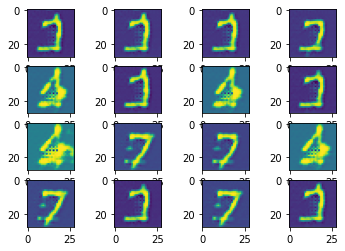

[Epoch: 2/10] D_loss: 0.488 G_loss: 1.034
Generated images for epoch: 2


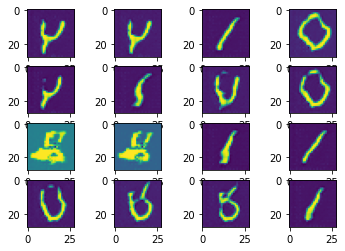

[Epoch: 3/10] D_loss: 0.583 G_loss: 0.859
Generated images for epoch: 3


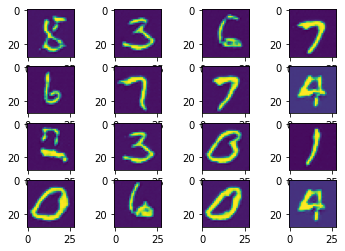

[Epoch: 4/10] D_loss: 0.562 G_loss: 0.894
Generated images for epoch: 4


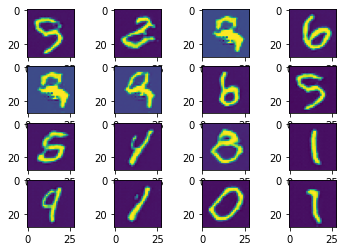

[Epoch: 5/10] D_loss: 0.589 G_loss: 0.861
Generated images for epoch: 5


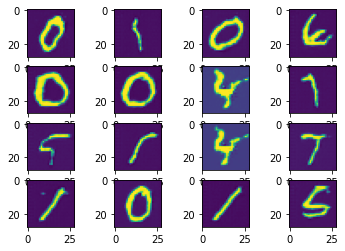

[Epoch: 6/10] D_loss: 0.606 G_loss: 0.825
Generated images for epoch: 6


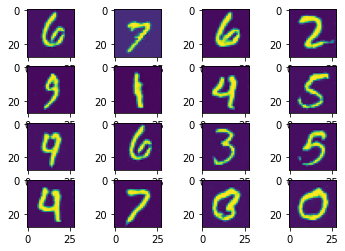

[Epoch: 7/10] D_loss: 0.613 G_loss: 0.821
Generated images for epoch: 7


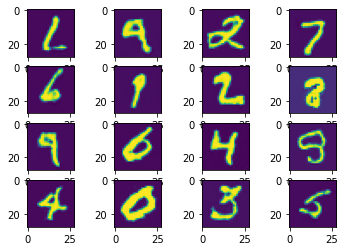

[Epoch: 8/10] D_loss: 0.620 G_loss: 0.807
Generated images for epoch: 8


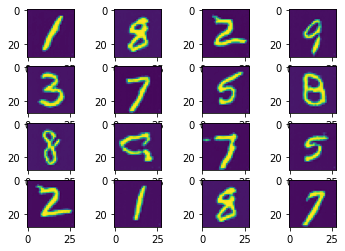

[Epoch: 9/10] D_loss: 0.633 G_loss: 0.793
Generated images for epoch: 9


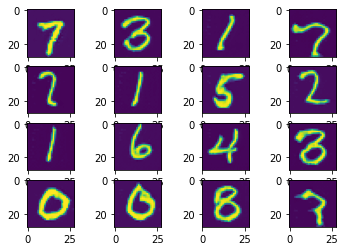

[Epoch: 10/10] D_loss: 0.629 G_loss: 0.801
Generated images for epoch: 10


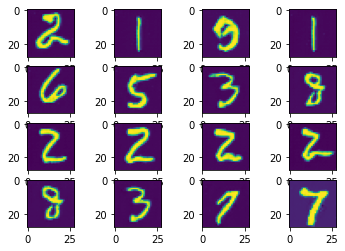

Model saved.
Training Finished.
Cost Time: 844.4458248615265s


In [10]:
# train
adversarial_loss = torch.nn.CrossEntropyLoss().to(device)

G.train()
D.train()

loss_g, loss_d = [], []
start_time = time.time()

for epoch in range(EPOCH):
  epoch += 1
  total_loss_g, total_loss_d=0, 0
  count_d = 0
  for i_iter, (images, label) in enumerate(train_loader):
    i_iter += 1

    # ------------------- #
    #   Train Generator
    # ------------------- #

    g_optimizer.zero_grad()
    # make some noise for Generator
    noise = torch.randn(images.shape[0], latent_dim, 1, 1)
    noise = noise.to(device)

    fake_label = torch.ones(images.shape[0], dtype=torch.long).to(device)

    # Generate a batch of images
    fake_inputs = G(noise)
    fake_outputs = D(fake_inputs)

    # G_Loss
    loss_g_value = adversarial_loss(fake_outputs, fake_label)
    loss_g_value.backward()
    g_optimizer.step()
    total_loss_g += loss_g_value
    loss_g.append(loss_g_value)





    # ----------------------- #
    #   Train Discriminator
    # ----------------------- #

    d_optimizer.zero_grad()
    
    real_inputs = images.to(device)
    real_label = torch.ones(real_inputs.shape[0], dtype=torch.long).to(device)
    fake_label = torch.zeros(fake_inputs.shape[0], dtype=torch.long).to(device)

    real_loss = adversarial_loss(D(real_inputs), real_label)
    fake_loss = adversarial_loss(D(fake_inputs.detach()), fake_label)

    loss_d_value = (real_loss + fake_loss) / 2
    loss_d_value.backward()
    d_optimizer.step()
    total_loss_d += loss_d_value
    loss_d.append(loss_d_value)

  total_loss_g /= len(train_loader)
  total_loss_d /= len(train_loader)
  g_scheduler.step()
  d_scheduler.step()
  print('[Epoch: {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, EPOCH, total_loss_d.item(), total_loss_g.item()))
  if epoch % 1 == 0:
      print('Generated images for epoch: {}'.format(epoch))
      imgs_numpy = fake_inputs.data.cpu().numpy()
      show_images(imgs_numpy[:16],epoch)
      plt.show()

torch.save(G, 'DCGAN_Generator.pth')
torch.save(D, 'DCGAN_Discriminator.pth')
print('Model saved.')

print('Training Finished.')
print('Cost Time: {}s'.format(time.time()-start_time))


    


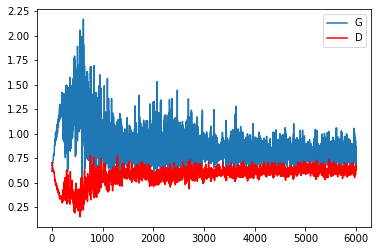

In [11]:
plt.plot(loss_g)
plt.plot(loss_d,'r')
plt.legend(['G','D'])
plt.show()

cuda:0


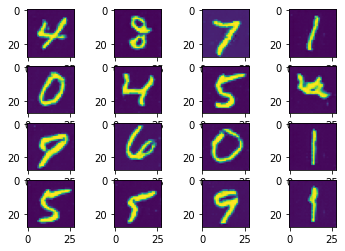

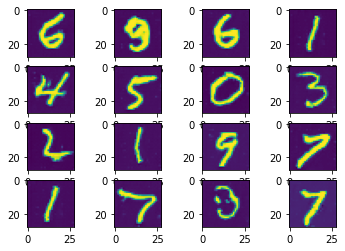

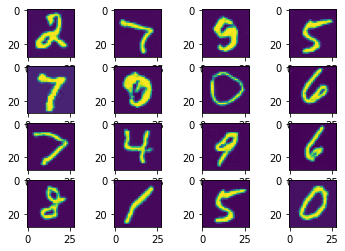

In [12]:
import torch
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
    plt.show()

flag_gpu = 1
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print(device)

G = torch.load('DCGAN_Generator.pth', map_location=device)
  
latent_dim = 10

## Exp:1
noise = torch.randn(20, latent_dim, 1, 1)
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])

## Exp:2
noise = torch.randn(20, latent_dim, 1, 1) *-10000
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])


## Exp:3
noise = torch.randn(20, latent_dim, 1, 1) *50000
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])
